## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [1]:
!unzip -qq '/fs/ess/PGS0333/BA_64061_KSU/data/dogs-vs-cats.zip'

In [2]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

**Configuring the model for training**

In [6]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [8]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [9]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [10]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [11]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [12]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - 6s 36ms/step - loss: 0.7175 - accuracy: 0.5253 - val_loss: 0.6899 - val_accuracy: 0.5090
Epoch 2/30
94/94 [==============================] - 3s 28ms/step - loss: 0.6870 - accuracy: 0.5727 - val_loss: 0.6668 - val_accuracy: 0.5880
Epoch 3/30
94/94 [==============================] - 3s 29ms/step - loss: 0.6443 - accuracy: 0.6480 - val_loss: 0.6093 - val_accuracy: 0.6640
Epoch 4/30
94/94 [==============================] - 3s 29ms/step - loss: 0.5855 - accuracy: 0.6957 - val_loss: 0.9432 - val_accuracy: 0.5630
Epoch 5/30
94/94 [==============================] - 3s 34ms/step - loss: 0.5324 - accuracy: 0.7390 - val_loss: 0.5633 - val_accuracy: 0.7070
Epoch 6/30
94/94 [==============================] - 3s 26ms/step - loss: 0.4849 - accuracy: 0.7700 - val_loss: 0.5928 - val_accuracy: 0.7210
Epoch 7/30
94/94 [==============================] - 3s 28ms/step - loss: 0.4447 - accuracy: 0.7897 - val_loss: 0.6139 - val_accuracy: 0.7020
Epoch 8/30
94

**Displaying curves of loss and accuracy during training**

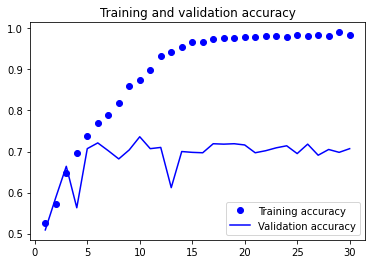

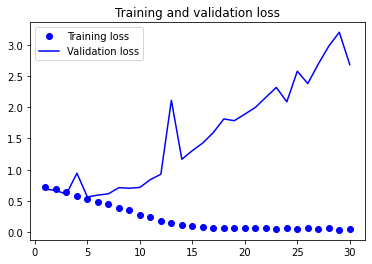

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [15]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 15ms/step - loss: 0.5255 - accuracy: 0.7470
Test accuracy: 0.747


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

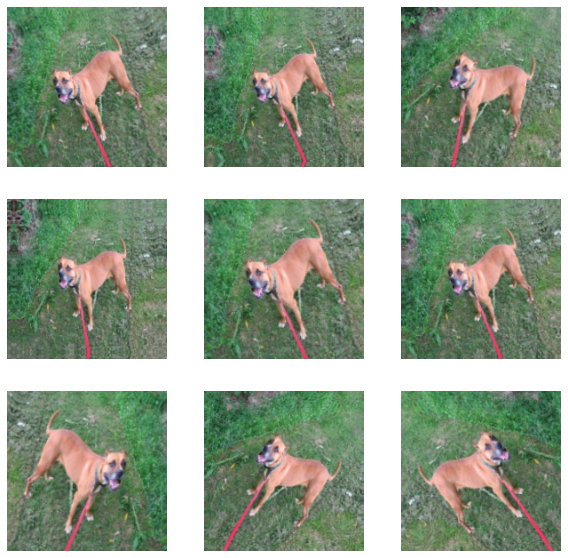

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [18]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
94/94 [==============================] - 4s 29ms/step - loss: 0.7066 - accuracy: 0.5197 - val_loss: 0.6972 - val_accuracy: 0.5010
Epoch 2/100
94/94 [==============================] - 3s 27ms/step - loss: 0.6895 - accuracy: 0.5580 - val_loss: 1.6756 - val_accuracy: 0.5000
Epoch 3/100
94/94 [==============================] - 3s 28ms/step - loss: 0.6701 - accuracy: 0.6060 - val_loss: 0.7642 - val_accuracy: 0.5710
Epoch 4/100
94/94 [==============================] - 3s 32ms/step - loss: 0.6533 - accuracy: 0.6383 - val_loss: 0.6818 - val_accuracy: 0.6220
Epoch 5/100
94/94 [==============================] - 3s 28ms/step - loss: 0.6358 - accuracy: 0.6660 - val_loss: 0.6208 - val_accuracy: 0.6610
Epoch 6/100
94/94 [==============================] - 3s 27ms/step - loss: 0.5990 - accuracy: 0.6970 - val_loss: 0.6101 - val_accuracy: 0.6940
Epoch 7/100
94/94 [==============================] - 3s 29ms/step - loss: 0.5858 - accuracy: 0.6927 - val_loss: 0.6206 - val_accuracy: 0.6650
Epoch 

**Evaluating the model on the test set**

In [20]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 14ms/step - loss: 0.3956 - accuracy: 0.8440
Test accuracy: 0.844


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [21]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [23]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [24]:
train_features.shape

(3000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [25]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
94/94 [==============================] - 1s 5ms/step - loss: 19.2821 - accuracy: 0.9297 - val_loss: 7.7577 - val_accuracy: 0.9600
Epoch 2/20
94/94 [==============================] - 0s 3ms/step - loss: 2.4581 - accuracy: 0.9813 - val_loss: 6.4577 - val_accuracy: 0.9680
Epoch 3/20
94/94 [==============================] - 0s 3ms/step - loss: 1.8305 - accuracy: 0.9873 - val_loss: 5.4886 - val_accuracy: 0.9720
Epoch 4/20
94/94 [==============================] - 0s 3ms/step - loss: 1.0502 - accuracy: 0.9917 - val_loss: 5.5082 - val_accuracy: 0.9730
Epoch 5/20
94/94 [==============================] - 0s 3ms/step - loss: 1.0211 - accuracy: 0.9913 - val_loss: 9.2668 - val_accuracy: 0.9590
Epoch 6/20
94/94 [==============================] - 0s 2ms/step - loss: 0.8345 - accuracy: 0.9913 - val_loss: 6.6224 - val_accuracy: 0.9680
Epoch 7/20
94/94 [==============================] - 0s 2ms/step - loss: 0.3342 - accuracy: 0.9963 - val_loss: 6.0409 - val_accuracy: 0.9760
Epoch 8/20
94/94 [=

**Plotting the results**

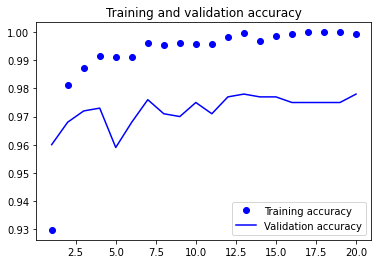

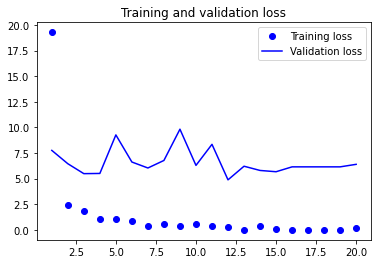

In [26]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [27]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [28]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [29]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [30]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
94/94 [==============================] - 5s 48ms/step - loss: 16.1852 - accuracy: 0.9070 - val_loss: 3.1014 - val_accuracy: 0.9690
Epoch 2/50
94/94 [==============================] - 4s 45ms/step - loss: 5.2580 - accuracy: 0.9537 - val_loss: 5.9140 - val_accuracy: 0.9670
Epoch 3/50
94/94 [==============================] - 4s 46ms/step - loss: 6.1179 - accuracy: 0.9547 - val_loss: 3.0332 - val_accuracy: 0.9820
Epoch 4/50
94/94 [==============================] - 4s 46ms/step - loss: 4.8091 - accuracy: 0.9640 - val_loss: 3.0725 - val_accuracy: 0.9850
Epoch 5/50
94/94 [==============================] - 4s 45ms/step - loss: 4.6338 - accuracy: 0.9643 - val_loss: 2.9619 - val_accuracy: 0.9760
Epoch 6/50
94/94 [==============================] - 4s 45ms/step - loss: 3.1727 - accuracy: 0.9667 - val_loss: 4.0726 - val_accuracy: 0.9680
Epoch 7/50
94/94 [==============================] - 4s 45ms/step - loss: 3.4149 - accuracy: 0.9687 - val_loss: 3.0023 - val_accuracy: 0.9760
Epoch 8/50
9

**Evaluating the model on the test set**

In [32]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 1.2217 - accuracy: 0.9750
Test accuracy: 0.975


### Fine-tuning a pretrained model

In [33]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [34]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [35]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - 6s 52ms/step - loss: 0.2493 - accuracy: 0.9897 - val_loss: 1.4020 - val_accuracy: 0.9760
Epoch 2/30
94/94 [==============================] - 5s 49ms/step - loss: 0.4185 - accuracy: 0.9890 - val_loss: 1.6460 - val_accuracy: 0.9750
Epoch 3/30
94/94 [==============================] - 5s 49ms/step - loss: 0.3424 - accuracy: 0.9850 - val_loss: 1.4852 - val_accuracy: 0.9760
Epoch 4/30
94/94 [==============================] - 5s 49ms/step - loss: 0.2378 - accuracy: 0.9907 - val_loss: 1.3249 - val_accuracy: 0.9790
Epoch 5/30
94/94 [==============================] - 5s 50ms/step - loss: 0.3200 - accuracy: 0.9863 - val_loss: 1.2808 - val_accuracy: 0.9770
Epoch 6/30
94/94 [==============================] - 5s 50ms/step - loss: 0.4004 - accuracy: 0.9873 - val_loss: 1.5241 - val_accuracy: 0.9740
Epoch 7/30
94/94 [==============================] - 5s 49ms/step - loss: 0.2025 - accuracy: 0.9927 - val_loss: 1.3027 - val_accuracy: 0.9730
Epoch 8/30
94

In [36]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 33ms/step - loss: 1.0825 - accuracy: 0.9780
Test accuracy: 0.978


## Summary